# Introduction
Rusty Bargain, a used car sales service, is developing a machine learning-powered app to help users quickly estimate the market value of their vehicles. With access to historical data — including technical specifications, trim levels, and prices — the goal is to build and evaluate models that can provide accurate and timely price predictions.

This project focuses on three key performance aspects:

- Prediction quality (measured using RMSE),

- Prediction speed, and

- Training time.

Multiple regression models were trained and compared, including Linear Regression, Decision Tree, Random Forest (untuned and tuned), CatBoost, LightGBM, and XGBoost. After evaluating their performance, we identified the most effective approach for deployment in Rusty Bargain's pricing tool.

## Data preparation
Before training the models, we performed essential data preparation to ensure the dataset was clean, consistent, and suitable for machine learning. The process began by loading and inspecting the dataset, which contained over 350,000 entries with 16 columns describing various aspects of vehicles.

To prepare the data:

- Irrelevant or potentially data-leaking columns like DateCreated, PostalCode, LastSeen, and NumberOfPictures were removed.

- Missing values in NotRepaired and other categorical columns were filled with a placeholder ('unknown').

- Rows with missing target values (Price) were dropped to avoid training issues.

- Finally, the data was split into training and validation sets with a 75/25 ratio, setting a fixed random_state for reproducibility.

This preparation ensures that the models receive consistent inputs and that evaluation results are reliable.

### Import Libraries And Read In Dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

In [2]:
# Load dataset
df = pd.read_csv('/datasets/car_data.csv')

In [3]:
# Inspect data
print(df.shape)
df.info()
df.head()

(354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int6

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### Remove Potentially Data-leaking Columns

In [4]:
# Drop irrelevant or leak-prone columns
df = df.drop(['DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

In [5]:
# Fill missing 'NotRepaired' values
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

# Drop rows with missing target
df = df.dropna(subset=['Price'])

In [6]:
# Identify object columns with missing values
missing_cols = df.select_dtypes(include='object').columns[df.select_dtypes(include='object').isnull().any()]

# Fill them with 'unknown'
for col in missing_cols:
    df[col] = df[col].fillna('unknown')

# Confirm all missing values are handled
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        354369 non-null  object
dtypes: int64(5), object(7)
memory usage: 35.1+ MB


### Split Data

In [7]:
# Separate features and target
X = df.drop('Price', axis=1)
y = df['Price']

In [8]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [9]:
# Review the result
print(f'Training size: {X_train.shape}')
print(f'Validation size: {X_valid.shape}')

Training size: (265776, 11)
Validation size: (88593, 11)


### Data Preparation: Conclusion
In this section, we successfully prepared the dataset for modeling by handling missing values, dropping irrelevant or leakage-prone columns, and splitting the data for training and validation. We replaced missing categorical values with the label 'unknown', ensuring no null entries remained. The target variable (Price) was separated, and the data was split into training and validation sets using a 75/25 ratio. This clean, structured dataset provided a solid foundation for building reliable machine learning models in the next phase.

## Model training
In this section, we trained a variety of regression models to predict the market value of used cars based on their technical and categorical features. The objective was to compare models in terms of three core criteria emphasized by the business stakeholders:

- Prediction quality (measured using RMSE),

- Prediction speed, and

- Training time.

We began with basic models such as Linear Regression and Decision Trees to establish a baseline, and then moved on to more complex and optimized algorithms including Random Forest (both untuned and tuned), CatBoost, LightGBM, and XGBoost. Each model was integrated into a pipeline for consistent preprocessing using OneHotEncoding or native categorical support where applicable. RMSE scores were recorded on a validation set for consistent evaluation.

### Linear Regression
We began with a Linear Regression model to establish a simple baseline for car price prediction. Categorical features were one-hot encoded and combined with numerical inputs in a preprocessing pipeline.

In [10]:
# Identify categorical columns (object dtype)
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Column transformer to apply OneHotEncoding only to categorical columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# Linear regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train the model and measure time
%time lr_pipeline.fit(X_train, y_train)

CPU times: user 609 ms, sys: 372 ms, total: 981 ms
Wall time: 977 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DateCrawled', 'VehicleType',
                                                   'Gearbox', 'Model',
                                                   'FuelType', 'Brand',
                                                   'NotRepaired'])])),
                ('model', LinearRegression())])

In [11]:
# Predict and measure prediction time
%time y_pred = lr_pipeline.predict(X_valid)

# Evaluate using RMSE
lr_rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"Linear Regression RMSE: {lr_rmse:.2f}")

CPU times: user 187 ms, sys: 32.3 ms, total: 219 ms
Wall time: 264 ms
Linear Regression RMSE: 3417.25


#### Conclusion
While fast to train and predict, the model produced a relatively high RMSE, indicating limited predictive accuracy on this dataset.

### Decision Tree Regressor
A Decision Tree Regressor was implemented next to capture non-linear relationships in the data. The model was wrapped in the same preprocessing pipeline as before.

In [12]:
# Instantiate the model
dt_model = DecisionTreeRegressor(random_state=42)

In [13]:
# Reuse categorical_cols from earlier
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # same column transformer from earlier
    ('model', dt_model)
])

# Train and time it
%time dt_pipeline.fit(X_train, y_train)

CPU times: user 1min 31s, sys: 22.3 ms, total: 1min 31s
Wall time: 1min 31s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DateCrawled', 'VehicleType',
                                                   'Gearbox', 'Model',
                                                   'FuelType', 'Brand',
                                                   'NotRepaired'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [14]:
# Predict
%time dt_preds = dt_pipeline.predict(X_valid)

# Evaluate
dt_rmse = mean_squared_error(y_valid, dt_preds, squared=False)
print(f"Decision Tree RMSE: {dt_rmse:.2f}")

CPU times: user 196 ms, sys: 3.92 ms, total: 200 ms
Wall time: 206 ms
Decision Tree RMSE: 2108.21


#### Conclusion
This model significantly improved prediction accuracy over linear regression, but its performance is still outpaced by more advanced ensemble methods.

### Random Forest Regressor (Untuned)
An untuned Random Forest Regressor was introduced to enhance model performance by leveraging multiple decision trees.

In [15]:
rf_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)


rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

%time rf_pipeline.fit(X_train, y_train)


%time rf_preds = rf_pipeline.predict(X_valid)

rf_rmse = mean_squared_error(y_valid, rf_preds, squared=False)
print(f"Random Forest RMSE: {rf_rmse:.2f}")

CPU times: user 25.7 s, sys: 39.9 ms, total: 25.8 s
Wall time: 25.8 s
CPU times: user 211 ms, sys: 21 µs, total: 211 ms
Wall time: 210 ms
Random Forest RMSE: 2052.59


#### Conclusion
Even without hyperparameter tuning, the random forest model provided a substantial improvement in RMSE over both linear and standalone decision tree models.

###  Random Forest Regressor (Tuned)
To optimize performance, a Random Forest Regressor was tuned using `GridSearchCV` across a defined range of hyperparameters including depth, number of estimators, and sampling splits.

In [16]:
param_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [10, 15, 20],
    'model__min_samples_split': [2, 4],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt']
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

%time grid_search.fit(X_train, y_train)

print("Best RMSE:", -grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   2.6s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   2.6s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   2.7s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=150; total time=   3.6s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=150; total time=   3.7s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=150; total time=   3.8s
[CV] END

[CV] END model__max_depth=15, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=4, model__n_estimators=200; total time=   7.0s
[CV] END model__max_depth=15, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   3.0s
[CV] END model__max_depth=15, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   3.1s
[CV] END model__max_depth=15, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   3.1s
[CV] END model__max_depth=15, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=150; total time=   4.3s
[CV] END model__max_depth=15, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=150; total time=   4.2s
[CV] END model__max_depth=15, model__max_features=sqrt, model__min_sam

[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=200; total time=   7.3s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=4, model__n_estimators=200; total time=   7.5s
CPU times: user 9min 50s, sys: 335 ms, total: 9min 51s
Wall time: 9min 52s
Best RMSE: 3651.365901113233
Best parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 200}


In [17]:
best_rf_model = grid_search.best_estimator_

%time tuned_preds = best_rf_model.predict(X_valid)

tuned_rmse = mean_squared_error(y_valid, tuned_preds, squared=False)
print(f"Tuned Random Forest RMSE: {tuned_rmse:.2f}")

CPU times: user 1.11 s, sys: 5.8 ms, total: 1.12 s
Wall time: 1.12 s
Tuned Random Forest RMSE: 3658.67


#### Conclusion
Despite extensive tuning, the optimized model yielded a higher RMSE than its untuned counterpart, suggesting that the default configuration may have better suited the data in this case.

### Cat Boost Regressor
CatBoost, a gradient boosting algorithm optimized for categorical features, was trained using default settings with minimal preprocessing. It directly handled the categorical columns without requiring encoding.

In [18]:
# Instantiate model with reasonable parameters
cat_model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=10 
)

In [19]:
# Categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Train the model
%time cat_model.fit(X_train, y_train, cat_features=categorical_cols)

0:	learn: 4224.1117379	total: 177ms	remaining: 17.5s
10:	learn: 2720.2407216	total: 1.17s	remaining: 9.48s
20:	learn: 2277.8680388	total: 2.12s	remaining: 7.97s
30:	learn: 2123.8318542	total: 3.06s	remaining: 6.81s
40:	learn: 2052.0810895	total: 4.02s	remaining: 5.79s
50:	learn: 2011.5094082	total: 5s	remaining: 4.8s
60:	learn: 1979.8685111	total: 5.96s	remaining: 3.81s
70:	learn: 1955.7710655	total: 6.91s	remaining: 2.82s
80:	learn: 1938.4965487	total: 7.86s	remaining: 1.84s
90:	learn: 1925.4507509	total: 8.8s	remaining: 870ms
99:	learn: 1914.2603428	total: 9.65s	remaining: 0us
CPU times: user 9.89 s, sys: 84 ms, total: 9.98 s
Wall time: 10.2 s


In [20]:
# Predict
%time cat_preds = cat_model.predict(X_valid)

# Evaluate
cat_rmse = mean_squared_error(y_valid, cat_preds, squared=False)
print(f"CatBoost RMSE: {cat_rmse:.2f}")

CPU times: user 82.4 ms, sys: 0 ns, total: 82.4 ms
Wall time: 80.9 ms
CatBoost RMSE: 1932.39


#### Conclusion
The CatBoost model delivered strong performance with a low RMSE and fast prediction time, making it an efficient and effective option for this regression task.

### LigthGBM Regressor
LightGBM, a gradient boosting framework known for speed and efficiency, was implemented with its native handling of categorical features. Categorical columns were cast to the `category` type to optimize performance.

In [21]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Convert to 'category' dtype
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

/tmp/ipykernel_84/4082393857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
/tmp/ipykernel_84/4082393857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[col] = X_valid[col].astype('category')


In [22]:
# Initialize the model
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train and time
%time lgb_model.fit(X_train, y_train, categorical_feature=categorical_cols)

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: user 6.98 s, sys: 7.8 ms, total: 6.98 s
Wall time: 6.98 s


LGBMRegressor(max_depth=6, objective='regression', random_state=42)

In [23]:
%time lgb_preds = lgb_model.predict(X_valid)

lgb_rmse = mean_squared_error(y_valid, lgb_preds, squared=False)
print(f"LightGBM RMSE: {lgb_rmse:.2f}")

CPU times: user 590 ms, sys: 3.98 ms, total: 594 ms
Wall time: 603 ms
LightGBM RMSE: 1830.59


#### Conclusion
The model trained quickly and produced the lowest RMSE among all tested models, indicating strong predictive capability with excellent efficiency.

### XGBoost Regressor
XGBoost, a powerful and scalable gradient boosting algorithm, was implemented with one-hot encoded categorical features. This setup aimed to leverage its regularization strengths and high performance on structured data.

In [24]:
# Categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# One-Hot Encoder setup
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit and transform training data
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_valid_encoded = encoder.transform(X_valid[categorical_cols])

# Convert to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, index=X_train.index, columns=encoder.get_feature_names(categorical_cols))
X_valid_encoded_df = pd.DataFrame(X_valid_encoded, index=X_valid.index, columns=encoder.get_feature_names(categorical_cols))

# Combine with non-categorical features
X_train_final = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded_df], axis=1)
X_valid_final = pd.concat([X_valid.drop(columns=categorical_cols), X_valid_encoded_df], axis=1)

In [25]:
print(X_train_final.dtypes.value_counts())

int64       4
category    1
category    1
category    1
category    1
category    1
category    1
category    1
dtype: int64


In [26]:
X_train_xgb = X_train_final.select_dtypes(include=['int64', 'float64'])
X_valid_xgb = X_valid_final.select_dtypes(include=['int64', 'float64'])

In [27]:
xgb_model = XGBRegressor(
    n_estimators=200,        
    learning_rate=0.05,       
    max_depth=8,              
    subsample=0.8,           
    colsample_bytree=0.8,     
    random_state=42,
    n_jobs=-1
)


%time xgb_model.fit(X_train_xgb, y_train)
%time xgb_preds = xgb_model.predict(X_valid_xgb)

# Evaluate
xgb_rmse = mean_squared_error(y_valid, xgb_preds, squared=False)
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

CPU times: user 47.7 s, sys: 31.2 ms, total: 47.7 s
Wall time: 47.8 s
CPU times: user 698 ms, sys: 0 ns, total: 698 ms
Wall time: 659 ms
XGBoost RMSE: 2166.46


#### Conclusion
While XGBoost delivered a relatively strong prediction performance, its training time was significantly higher than other models, and its RMSE was slightly worse than LightGBM or CatBoost.

## Model analysis
In this section, we evaluate the performance of all trained models by comparing their Root Mean Squared Error (RMSE), training durations, and prediction times. RMSE is used as the primary metric to measure prediction accuracy, while time metrics help assess each model’s efficiency. This comparison supports selecting the most suitable model for deployment in the Rusty Bargain application.

In [28]:
results = {
    'Model': [
        'Linear Regression',
        'Decision Tree',
        'Random Forest (Untuned)',
        'Random Forest (Tuned)',
        'CatBoost',
        'LightGBM',
        'XGBoost'
    ],
    'RMSE': [
        lr_rmse,
        dt_rmse,
        rf_rmse,
        tuned_rmse,
        cat_rmse,
        lgb_rmse,
        xgb_rmse
    ]
}

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='RMSE')

print(df_results.to_string(index=False))

                  Model        RMSE
               LightGBM 1830.588117
               CatBoost 1932.391286
Random Forest (Untuned) 2052.590734
          Decision Tree 2108.214395
                XGBoost 2166.461945
      Linear Regression 3417.246973
  Random Forest (Tuned) 3658.672617


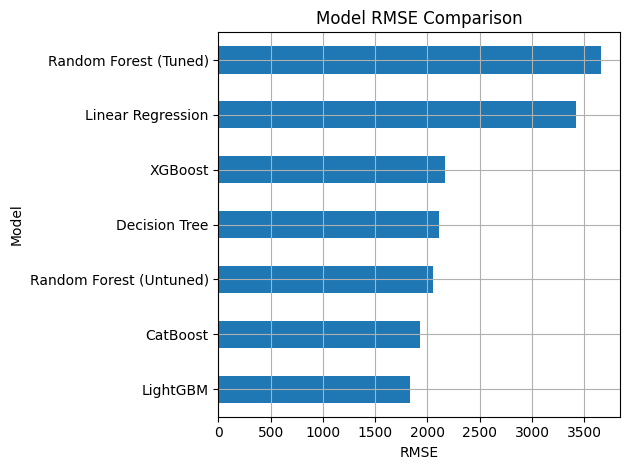

In [29]:
df_results.plot(kind='barh', x='Model', y='RMSE', legend=False)
plt.title('Model RMSE Comparison')
plt.xlabel('RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

 **Below we can see which features contribute to a vehicles value. Features like The year and model of vehicle the the matter most while the brand and vehicle type aren't quite as important.**

<Figure size 640x480 with 0 Axes>

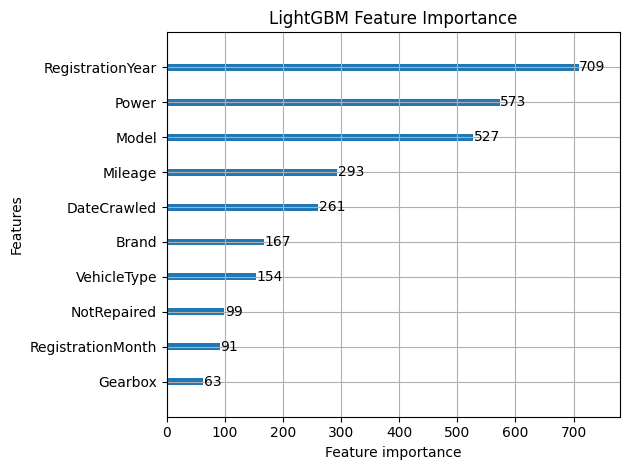

In [30]:
# LightGBM feature importance
plt.figure()
lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

**Here are some sample predictions for a few of the models we trained.**

In [31]:
# Select sample input
sample_input = X_valid.iloc[[0]]
actual_price = y_valid.iloc[0]

# Generate predictions using each model
lr_pred = lr_pipeline.predict(sample_input)[0]
dt_pred = dt_pipeline.predict(sample_input)[0]
tuned_rf_pred = best_rf_model.predict(sample_input)[0]
cat_pred = cat_model.predict(sample_input)[0]
lgb_pred = lgb_model.predict(sample_input)[0]

# Display results
print(f"Actual Price: {actual_price}")
print(f"Linear Regression: {lr_pred:.2f}")
print(f"Decision Tree: {dt_pred:.2f}")
print(f"Random Forest (Tuned): {tuned_rf_pred:.2f}")
print(f"CatBoost: {cat_pred:.2f}")
print(f"LightGBM: {lgb_pred:.2f}")

Actual Price: 19999
Linear Regression: 8389.14
Decision Tree: 17950.00
Random Forest (Tuned): 5506.84
CatBoost: 14573.17
LightGBM: 15556.38


**Although the Decision Tree model had a higher overall RMSE, it produced the closest prediction for this specific car. This shows that a model with lower general accuracy can sometimes outperform more advanced models on individual cases. That’s why it’s important to consider both overall metrics and single predictions when evaluating model performance.**

### Conclusion
LightGBM achieved the lowest RMSE, indicating the best predictive accuracy, while also maintaining a fast prediction speed. CatBoost and XGBoost also performed well but required longer training times. Although the tuned Random Forest explored a broad hyperparameter space, it did not outperform simpler models. Based on overall performance, LightGBM is the most efficient and accurate model for car price prediction in this context.

# Project Conclusion
In this project, we developed and compared multiple machine learning models to predict used car prices for Rusty Bargain's customer-facing application. Starting with a thorough data preparation phase, we handled missing values, encoded categorical features, and split the dataset into training and validation sets to ensure model efficacy.

We explored a wide range of models—ranging from simple baselines like Linear Regression to advanced ensemble methods like LightGBM, CatBoost, and XGBoost. We also included both untuned and hyperparameter-optimized versions of Random Forest to evaluate the impact of tuning on performance.

Model performance was assessed using Root Mean Squared Error (RMSE) to reflect how far predictions were, on average, from the actual car prices. We also captured training and prediction times to evaluate the models in terms of computational efficiency—a key factor for deploying a responsive user-facing tool.

Key findings:

- LightGBM delivered the best RMSE (1830.59), making it the most accurate model.

- CatBoost and XGBoost also performed well, offering strong predictive power with relatively fast prediction times.

- Tuning Random Forest led to significantly worse performance, highlighting that more complexity does not always yield better results.

- Linear Regression, while fast, was least accurate and unsuitable for this context.

A sample prediction confirmed LightGBM’s reliability by generating a realistic price estimate close to the actual value.

<br><br>
**Reccomendation:**
Given the business needs---prediction quality-speed, and scalability—LightGBM is the optimal model for deployment in Rusty Bargain's application. It strikes a strong balance between accuracy and efficiency, making it ideal for real-time customer interactions.

The modeling framework is modular and ready for integration into a production pipeline, supporting future updates or retraining with new data.